# Logistic Regression: Predicting off of 5 prev. games' data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
cat_to_meaning = {"0": "[-inf, -2%]", "1": "[-2, -0%]", "2":"[+0%, +2%]", "3":"[+2%, +inf]"}
cats = pd.DataFrame(cat_to_meaning.items())
cats = cats.drop(0, axis = 1)
cats.columns = ["Interval of Profit Margin"]

In [3]:
# read in Alec's cleaned data
Xdf = pd.read_csv("X.csv", header = None)
y = pd.read_csv("y.csv", header = None)

col_names = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY',
       'HR', 'AR', 'MAXH', 'MAXD', 'MAXA']
print(col_names)
extended_col_names = col_names.copy()
for i in range(5):
    extended_col_names.extend([name + "_H_" + str(i) for name in col_names])
for i in range(5):
    extended_col_names.extend([name + "_A_" + str(i) for name in col_names])

extended_col_names = [ele for ele in extended_col_names if ele not in ['MAXH','MAXD','MAXA']]

Xdf.columns = extended_col_names

#WE DON'T WANT TO TRAIN ON GAME STATS, ONLY PREVIOUS
Xdf.drop(['FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG','HTR', 'HS', 'AS', 'HST',
        'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY','HR', 'AR'], axis = 1, inplace = True)

['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'MAXH', 'MAXD', 'MAXA']


In [4]:
trans_y = y.transpose()
val_counts = trans_y.value_counts()
int_counts = pd.DataFrame(val_counts)
int_counts.columns = ["Number of Games"]
int_counts.reset_index(inplace = True)
int_counts = pd.concat([cats, int_counts], axis = 1)
int_counts = int_counts.iloc[:, [0,2]]
int_counts

,Interval of Profit Margin,Number of Games
0,"[-inf, -2%]",3110
1,"[-2, -0%]",1719
2,"[+0%, +2%]",529
3,"[+2%, +inf]",51


## Multiclass Classification

Predicting one of the four classes shown above using sklearn's Logistic Regression model, with the data from the previous five games used to predict (standardized). The model's balanced accuracy score would be 25% if it predicted randomly between the four classes, and it achieves a slightly higher accuracy of 30.57%.

In [5]:
y = y.iloc[0].values
y = np.array([num + 2 for num in y])
X = Xdf.values

In [6]:
assert len(X) == len(y)
print("Working with", len(X), "rows of data")
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = .5, random_state = 4)
print(len(X_tr), "rows in training data", len(X_te), "rows in testing data")

Working with 5409 rows of data
2704 rows in training data 2705 rows in testing data


In [7]:
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_te_scaled = scaler.transform(X_te)

In [8]:
logreg_m = LogisticRegression(solver = "newton-cholesky", random_state = 10)
logreg_m.fit(X_tr_scaled, y_tr)
y_pred_m = logreg_m.predict(X_te_scaled)
log_reg_m_acc = accuracy_score(y_te, y_pred_m)

In [9]:
print("Accuracy of Multi-class Logistic Regression Model: ", np.round(log_reg_m_acc, 4))

Accuracy of Multi-class Logistic Regression Model:  0.6248


In [10]:
print("Balanced Accuracy Score (accounting for class imabalances): ", np.round(balanced_accuracy_score(y_te, y_pred_m), 4))

Balanced Accuracy Score (accounting for class imabalances):  0.3057


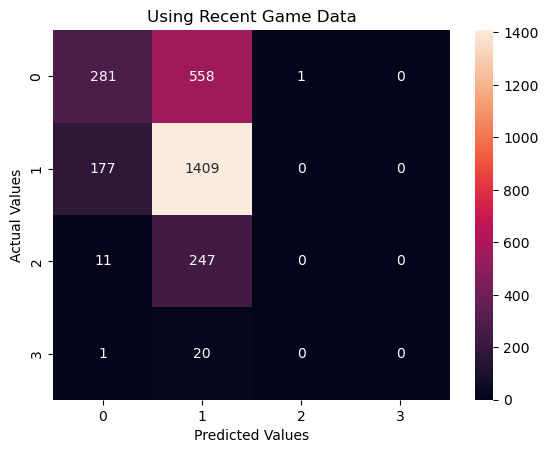

In [11]:
cfm1 = confusion_matrix(y_te, y_pred_m)
sns.heatmap(cfm1, annot = True, fmt = "d")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.title("Using Recent Game Data")
plt.savefig("LESS_CONF_M1.png", dpi = 400)
#plt.show()

Only 1 instance that was predicted as being an arbitrage opportunity where there would be a profit in category 2, corresponding to a positive profit margin between 0 and 2 percent. This was an incorrect classification too, with the actual value being class 0, with a loss of between -inf and -2% occurring given a bet.

For the testing dataset, 

In [12]:
ind_of_pred_arb = np.where(y_pred_m >= 2)[0][0]
ind_of_pred_arb
#[pred for pred in y_pred_m if pred >= 2], np.where(y_pred_m >= 2)[0]

1279

In [13]:
# The row of the instance that was incorectly predcited as the arbitrage opportunity.
pd.DataFrame(dict(zip(Xdf.columns.tolist(), X_te[ind_of_pred_arb])), index = np.arange(1))

,Date,HomeTeam,AwayTeam,Date_H_0,HomeTeam_H_0,AwayTeam_H_0,FTHG_H_0,FTAG_H_0,FTR_H_0,HTHG_H_0,...,AF_A_4,HC_A_4,AC_A_4,HY_A_4,AY_A_4,HR_A_4,AR_A_4,MAXH_A_4,MAXD_A_4,MAXA_A_4
0,733684.0,2.0,12.0,733270.0,2.0,16.0,2.0,3.0,1.0,1.0,...,10.0,20.0,3.0,1.0,1.0,0.0,0.0,1.22,6.5,17.0


## Binary Classification
Turning this into a binary classification problem by classifying negative profit margins as no arbitrage opportunity, class 0; positive profit margins as arbitrage opportunity, class 1.

In [14]:
def multi_to_binary(num):
    """
    Using the definition of categories based on profit margins
    given above, categorizes negative profit margins as class 0,
    and positive profit margins as class 1.
    """
    if num <= 2:
        return 0
    else:
        return 1

In [15]:
# Custom threshold
def class1_threshold(lr_model, X_pred_on, thresh):
    """
    Returns custom predictions like LogisticRegression.predict() except using 
    a custom threshold as opposed to 0.5, the default threshold.
    """
    prob_in_class_1 = lr_model.predict_proba(X_pred_on)
    one_for_class_1 = (prob_in_class_1[:, 1] > thresh).astype(int)
    return one_for_class_1

Using the same training and testing data as what was used for the multi-class problem

In [16]:

b_y_te = [multi_to_binary(num) for num in y_te]
b_y_tr = [multi_to_binary(num) for num in y_tr]
perc_arb = sum(b_y_te + b_y_tr)/(len(b_y_te) + len(b_y_tr))

print("Percent of the observations that are arbitrage opportunities: ", np.round(perc_arb, 4))
logreg_b = LogisticRegression(solver = "newton-cholesky", random_state = 11)
logreg_b.fit(X_tr_scaled, b_y_tr)
y_pred_b = logreg_b.predict(X_te_scaled)

# Get the probabilities for later roc curve plotting
y_pred_probs_b = logreg_b.predict_proba(X_te_scaled)[:, 1]
# Predicted classes using custom threshold (probability needed to predict class 1)
custom_thresh = perc_arb
y_pred_b2 = class1_threshold(logreg_b, X_te_scaled, custom_thresh)

log_reg_b_acc1 = accuracy_score(b_y_te, y_pred_b)
log_reg_b_acc2 = accuracy_score(b_y_te, y_pred_b2)
print("Accuracy of Log. Reg. Model for Binary Classification Problem: ", np.round(log_reg_b_acc1, 4))
print("Accuracy of Log. Reg. Model for Binary Classification Problem w/ threshold", np.round(custom_thresh, 4), ":", np.round(log_reg_b_acc2, 4))

Percent of the observations that are arbitrage opportunities:  0.1072
Accuracy of Log. Reg. Model for Binary Classification Problem:  0.8969
Accuracy of Log. Reg. Model for Binary Classification Problem w/ threshold 0.1072 : 0.5375


The percent of the games where there is an arbitrage opportunity (or a positive profit margin that can be made from an unbiased arbitrage bet) is about 0.1072. This can be used as the custom probability threshold used to classify a prediction as class 1. In other words, if the model thinks the probability of an instance being an arbitrage opportunity is above 0.1072, it will be predicted as an arbitrage opportunity using this threshold. Using the custom threshold, the balanced accuracy score is higher.

In [17]:
bal_acc1 = balanced_accuracy_score(b_y_te, y_pred_b)
bal_acc2 = balanced_accuracy_score(b_y_te, y_pred_b2)
print("Balanced Accuracy w/ default Log. Reg. threshold 0.5:", np.round(bal_acc1, 4))
print("Balanced Accuracy w/ custom Log. Reg threshold 0.1072:", np.round(bal_acc2, 4))

Balanced Accuracy w/ default Log. Reg. threshold 0.5: 0.5
Balanced Accuracy w/ custom Log. Reg threshold 0.1072: 0.5804


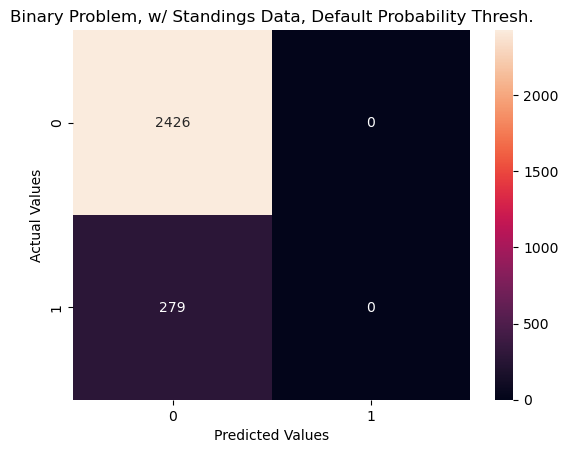

In [18]:
plt.title("Binary Problem, w/ Standings Data, Default Probability Thresh.")
sns.heatmap(confusion_matrix(b_y_te, y_pred_b), annot = True, fmt = "d")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig("")
plt.show()

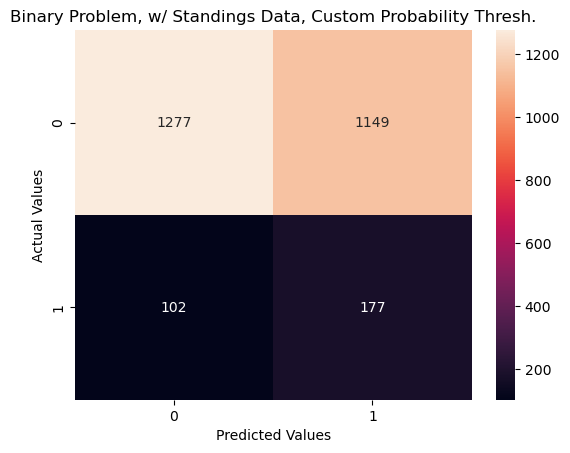

In [19]:
plt.title("Binary Problem, w/ Standings Data, Custom Probability Thresh.")
sns.heatmap(confusion_matrix(b_y_te, y_pred_b2), annot = True, fmt = "d")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

# Standings Data from Previous Season

In order to incorporate more data that would have been known at the time of each game, I will be merging the game & odds data with statistics from ESPN for premier league teams. I will merge each match with relevant data for the previous year's season. For instance, for a game played in September 2019, I will merge the row of the game with data for the home and away teams playing from the previous 2018-2019 season, given that premier league matches take place between August and May.

In [20]:
dts = [datetime.date.fromordinal(ordinal) for ordinal in Xdf["Date"]]
Xdf["Dt"] = dts
Xdf["Yr"] = Xdf.apply(lambda r: r["Dt"].year, axis = 1)

In [21]:
# See other notebook for details on web scraping to get this data
player = pd.read_excel("espn_scorer_assister.xlsx")
print(player.shape)
player.head()

(4081, 10)


,Scorer_RK,Scorer_Name,Scorer_P,Scorer_G,Assister_RK,Assister_Name,Assister_P,Assister_A,Season,Team
0,1,Carlos Tevez,35.0,23.0,1,Craig Bellamy,32.0,8.0,2009-2010,Manchester City
1,2,Emmanuel Adebayor,26.0,14.0,2,Carlos Tevez,35.0,7.0,2009-2010,Manchester City
2,3,Craig Bellamy,32.0,10.0,2,Gareth Barry,34.0,7.0,2009-2010,Manchester City
3,4,Shaun Wright-Phillips,30.0,4.0,2,Shaun Wright-Phillips,30.0,7.0,2009-2010,Manchester City
4,4,Martin Petrov,16.0,4.0,5,Adam Johnson,16.0,5.0,2009-2010,Manchester City


In [22]:
standings = pd.read_excel("premier_standings.xlsx")
standings.head()

,Team,GP,W,D,L,F,A,GD,P,Season,Rank
0,Chelsea,38,27,5,6,103,32,71,86,2009-2010,1
1,Manchester United,38,27,4,7,86,28,58,85,2009-2010,2
2,Arsenal,38,23,6,9,83,41,42,75,2009-2010,3
3,Tottenham Hotspur,38,21,7,10,67,41,26,70,2009-2010,4
4,Manchester City,38,18,13,7,73,45,28,67,2009-2010,5


In [23]:
def what_is_prev_season(row):
    """
    For a given date of a match, get the previous season that there would have been data for.
    """
    date, year = row["Dt"], row["Yr"]
    
    if date > datetime.date(year = year-1, day = 1, month = 8) and date <= datetime.date(year = year, day = 30, month = 5):
        season = str(year-2) + "-" + str(year-1)
    else:
        season = str(year-1) + "-" + str(year)
    
    return season

In [24]:
Xdf["Prev. Season"] = Xdf.apply(what_is_prev_season, axis = 1)

In [25]:
# Add a suffix so the new columns in premier will be indicative of whether the stat refers to the Home or Away team
home_standings = standings.add_suffix("_Home")
away_standings = standings.add_suffix("_Away")

In [26]:
# Alec encoded HomeTeam as integers using this dictionary, I am going to un-encode them in order to merge
team_int_to_str = {0: 'Arsenal', 1: 'Bolton', 2: 'Everton', 3: 'Hull', 4: 'Middlesbrough', 5: 'Sunderland', 
 6: 'West Ham', 7: 'Chelsea', 8: 'Aston Villa', 9: 'Man United', 10: 'Liverpool', 
 11: 'Newcastle', 12: 'Stoke', 13: 'Tottenham', 14: 'West Brom', 15: 'Fulham', 16: 'Blackburn', 
 17: 'Man City', 18: 'Wigan', 19: 'Portsmouth', 20: 'Wolves', 21: 'Birmingham', 22: 'Burnley', 
 23: 'Blackpool', 24: 'QPR', 25: 'Swansea', 26: 'Norwich', 27: 'Reading', 28: 'Southampton', 
 29: 'Crystal Palace', 30: 'Cardiff', 31: 'Leicester', 32: 'Bournemouth', 33: 'Watford', 
 34: 'Brighton', 35: 'Huddersfield', 36: 'Sheffield United', 37: 'Leeds', 38: 'Brentford', 39: "Nott'm Forest"}


Xdf["HomeTeamStr"] = Xdf.apply(lambda r: team_int_to_str[r["HomeTeam"]], axis = 1)
Xdf["AwayTeamStr"] = Xdf.apply(lambda r: team_int_to_str[r["AwayTeam"]], axis = 1)
# Keeping track of what columns are being added
before_getting_standings = set(Xdf.columns)

In [27]:
# Home
Xdf = Xdf.merge(home_standings, left_on = ["HomeTeamStr", "Prev. Season"], 
                right_on = ["Team_Home", "Season_Home"], how = "left", suffixes = ("_p", "_s"))
# Home team standing columns
home_team_stats = list(set(Xdf.columns).difference(before_getting_standings))
before_getting_away = set(Xdf.columns)
# Away
Xdf = Xdf.merge(away_standings, left_on = ["AwayTeamStr", "Prev. Season"], 
                right_on = ["Team_Away", "Season_Away"], how = "left", suffixes = ("_p", "_s"))
away_team_stats = list(set(Xdf.columns).difference(before_getting_away))

In [28]:
# Remove info unnecessary for prediction like repeated cols of what team is playing and what season this data is for
team_stats = list(set(home_team_stats + away_team_stats).difference(set({"Season_Away",
                                     "Season_Home", "Team_Away", "Team_Home"}))) 
# Unfortunately some of the team statistics data is missing :(
team_stats_df = Xdf[team_stats]
team_stats_df.fillna(0, inplace = True)

In [29]:
prev_Xdf = Xdf[before_getting_standings]
Xdf = pd.concat([team_stats_df, prev_Xdf], axis = 1)
print("df shape:", Xdf.shape)

df shape: (5409, 266)


Do the models improve after adding data about standings from the previous year?

### 1. Multiclass Classification

Previously using 5 prev. games' data: 
- Accuracy: 0.6248
- Balanced Accuracy: 0.3057

Now using 5 prev. games' data & previous season's standings
- Accuracy: 0.6322
- Balanced Accuracy: 0.3162

In [30]:
# Drop columns I created for temporary use
temp_cols = ["Dt", "Yr", "HomeTeamStr", "AwayTeamStr", "Prev. Season"]
X_inp = Xdf.drop(columns = temp_cols)

Working with 5409 rows of data
2704 rows in training data 2705 rows in testing data
Accuracy of Multi-class Logistic Regression Model:  0.6322
Balanced Accuracy Score (accounting for class imabalances):  0.3162


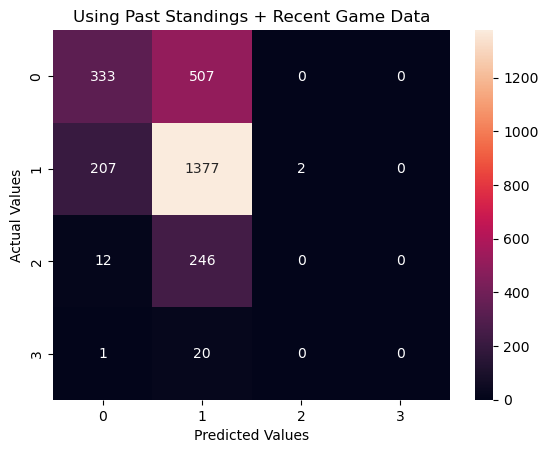

In [31]:
X = X_inp.values

assert len(X) == len(y)
print("Working with", len(X), "rows of data")
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = .5, random_state = 4)
print(len(X_tr), "rows in training data", len(X_te), "rows in testing data")

scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_te_scaled = scaler.transform(X_te)

logreg_m = LogisticRegression(solver = "newton-cholesky", random_state = 10)
logreg_m.fit(X_tr_scaled, y_tr)
y_pred_m = logreg_m.predict(X_te_scaled)
log_reg_m_acc = accuracy_score(y_te, y_pred_m)

print("Accuracy of Multi-class Logistic Regression Model: ", np.round(log_reg_m_acc, 4))

print("Balanced Accuracy Score (accounting for class imabalances): ", np.round(balanced_accuracy_score(y_te, y_pred_m), 4))

cfm2 = confusion_matrix(y_te, y_pred_m)
sns.heatmap(cfm2, annot = True, fmt = "d")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.title("Using Past Standings + Recent Game Data")
plt.savefig("MORE_CONF_M2.png", dpi = 400)
#plt.show()

### 2. Binary Classification

Previously using 5 games' data:
- Accuracy: 0.8969, Balanced Accuracy: 0.5
- Threshold .1072, Accuracy: 0.5375, Balanced Accuracy: 0.5804

Now:
- Accuracy: 0.8969, Balanced Accuracy: 0.5
- Threshold .1072, Accuracy: 0.5652, Balanced Accuracy: 0.5911

In [32]:
logreg_b = LogisticRegression(solver = "newton-cholesky", random_state = 11)
logreg_b.fit(X_tr_scaled, b_y_tr)
y_pred_b = logreg_b.predict(X_te_scaled)

# Get the probabilities for later roc curve plotting
y_pred_probs_b2 = logreg_b.predict_proba(X_te_scaled)[:, 1]
y_pred_b2 = class1_threshold(logreg_b, X_te_scaled, custom_thresh)

log_reg_b_acc1 = accuracy_score(b_y_te, y_pred_b)
log_reg_b_acc2 = accuracy_score(b_y_te, y_pred_b2)
print("Accuracy of Log. Reg. Model for Binary Classification Problem: ", np.round(log_reg_b_acc1, 4))
print("Accuracy of Log. Reg. Model for Binary Classification Problem w/ threshold", np.round(custom_thresh, 4), ":", np.round(log_reg_b_acc2, 4))

Accuracy of Log. Reg. Model for Binary Classification Problem:  0.8969
Accuracy of Log. Reg. Model for Binary Classification Problem w/ threshold 0.1072 : 0.5652


In [33]:
bal_acc1 = balanced_accuracy_score(b_y_te, y_pred_b)
bal_acc2 = balanced_accuracy_score(b_y_te, y_pred_b2)
print("Balanced Accuracy w/ default Log. Reg. threshold 0.5:", np.round(bal_acc1, 6))
print("Balanced Accuracy w/ custom Log. Reg threshold 0.1072:", np.round(bal_acc2, 4))

Balanced Accuracy w/ default Log. Reg. threshold 0.5: 0.5
Balanced Accuracy w/ custom Log. Reg threshold 0.1072: 0.5911


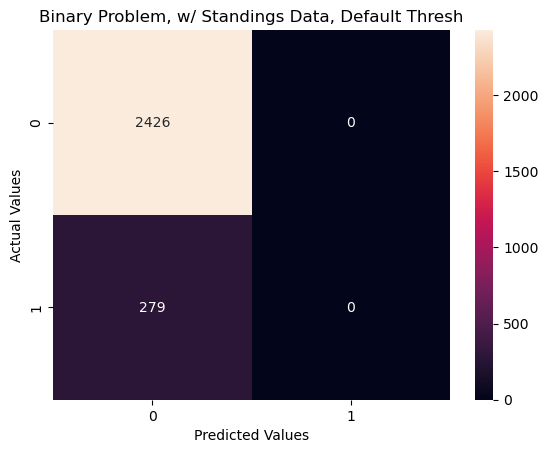

In [34]:
plt.title("Binary Problem, w/ Standings Data, Default Thresh")
sns.heatmap(confusion_matrix(b_y_te, y_pred_b), annot = True, fmt = "d")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

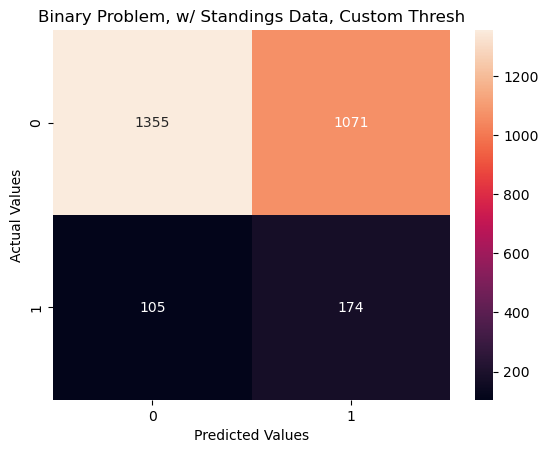

In [35]:
plt.title("Binary Problem, w/ Standings Data, Custom Thresh")
sns.heatmap(confusion_matrix(b_y_te, y_pred_b2), annot = True, fmt = "d")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

## Comparing Models: ROC, AUC

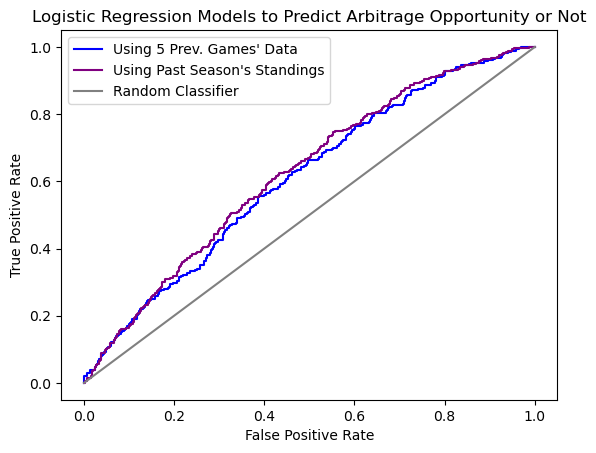

In [36]:
#| fig-cap: Comparing Logistic Regression models with different features to predict on
plt.rcParams["figure.dpi"] = 100

# just using last 5 games' data
logreg1_fpr, logreg1_tpr, logreg1_thresh = roc_curve(b_y_te, y_pred_probs_b)
# using past season's standings
logreg2_fpr, logreg2_tpr, logreg2_thresh = roc_curve(b_y_te, y_pred_probs_b2)

plt.title("Logistic Regression Models to Predict Arbitrage Opportunity or Not")
plt.plot(logreg1_fpr, logreg1_tpr, label = "Using 5 Prev. Games' Data", color = "blue")
plt.plot(logreg2_fpr, logreg2_tpr, label = "Using Past Season's Standings", color = "purple")
plt.plot(logreg2_fpr, logreg2_fpr, label = "Random Classifier", color = "gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [37]:
prev5_b_auc = auc(logreg1_fpr, logreg1_tpr)
stand_b_auc = auc(logreg2_fpr, logreg2_tpr)
print("AUC for log. reg. model to predict on previous games", np.round(prev5_b_auc, 4))
print("AUC for log. reg. model to predict on previous games + last season's standings", np.round(stand_b_auc, 4))

AUC for log. reg. model to predict on previous games 0.6093
AUC for log. reg. model to predict on previous games + last season's standings 0.6248


The logistic regression models to predict whether there are arbitrage oppportunities seems to be ever-so-slightly better when incorporating data from the previous season's standings. Some next models to make would be doing PCA, testing which features are really the most important potentially by going through different C parameters for inverse regularization strength, and by incorporating top scorer/assist data that I have scraped from the ESPN website.